In [202]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import SGD
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

import warnings 

warnings.filterwarnings('ignore')

In [203]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Available device: {device}")

Available device: cuda


In [204]:
reg_22 = pd.read_csv('2022_reg.csv', sep=';', encoding='latin_1')
reg_23 = pd.read_csv('2023_reg.csv', sep=';', encoding='latin_1')
# reg_22.head()
# reg_23.head()

In [205]:
# reg_22.info()
# reg_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rk      812 non-null    int64  
 1   Player  812 non-null    object 
 2   Pos     812 non-null    object 
 3   Age     812 non-null    int64  
 4   Tm      812 non-null    object 
 5   G       812 non-null    int64  
 6   GS      812 non-null    int64  
 7   MP      812 non-null    float64
 8   FG      812 non-null    float64
 9   FGA     812 non-null    float64
 10  FG%     812 non-null    float64
 11  3P      812 non-null    float64
 12  3PA     812 non-null    float64
 13  3P%     812 non-null    float64
 14  2P      812 non-null    float64
 15  2PA     812 non-null    float64
 16  2P%     812 non-null    float64
 17  eFG%    812 non-null    float64
 18  FT      812 non-null    float64
 19  FTA     812 non-null    float64
 20  FT%     812 non-null    float64
 21  ORB     812 non-null    float64
 22  DR

In [206]:
for player, number in reg_22["Player"].value_counts().items():
    if number > 1: 
        reg_22 = reg_22[reg_22["Player"] != player]

for player, number in reg_23["Player"].value_counts().items():
    if number > 1: 
        reg_22 = reg_22[reg_22["Player"] != player]


In [207]:
pts_23 = []

for name in reg_22["Player"]:
    if name in reg_23["Player"].unique():
        pts_23.append(reg_23.loc[reg_23["Player"] == name]["PTS"].values[0])
    else:
         reg_22 = reg_22[reg_22["Player"] != name]

In [208]:
reg_22["PTS_23"] = pts_23

## **Columns**

### Dropping:
* Rk
* Player
* Pos
* Tm
* FG%
* 3P%
* 2P%
* eFG%
* FT%
* DRB
* TRB
* STL
* BLK
* PF

In [209]:
dropping = ["Rk", "Player", "Pos", "Tm", "FG%", "3P%", "2P%", "eFG%", "FT%", "TRB", "DRB", "STL", "BLK", "PF"]

In [210]:
reg_22 = reg_22.drop(columns=dropping)

In [211]:
features = reg_22.columns[:-1]
target = reg_22.columns[-1]

In [212]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(reg_22[features],         
                                                    reg_22[target],
                                                    test_size=0.2, 
                                                    random_state=42)

In [213]:
for column in features:
    
    highest_value = max(np.abs(x_train[column]))
    
    x_train[column] = x_train[column] / highest_value
    
    x_test[column] = x_test[column] / highest_value

In [214]:
x_train = torch.from_numpy(np.array(x_train)).type(torch.FloatTensor)
y_train = torch.from_numpy(np.array(y_train)).type(torch.FloatTensor).reshape([-1,1])

x_test = torch.from_numpy(np.array(x_test)).type(torch.FloatTensor)
y_test = torch.from_numpy(np.array(y_test)).type(torch.FloatTensor).reshape([-1,1])

In [215]:
x_train = x_train.to(device)
y_train = y_train.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

In [227]:
x_train.shape


torch.Size([259, 16])

In [216]:
training_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [236]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        # self.fc1 = nn.Linear(input_size, 4096)
        # self.fc2 = nn.Linear(4096, 2048)
        # self.fc3 = nn.Linear(2048, 1024)
        # self.fc4 = nn.Linear(1024, 512)
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 1)
        self.relu = torch.nn.ReLU()
        self.dropout1 = nn.Dropout(.2)

    def forward(self, x):
        
        x = self.relu(self.fc1(x))
        # x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        # x = self.dropout1(x)
        x = self.relu(self.fc3(x))
        # x = self.dropout1(x)
        x = self.relu(self.fc4(x))
        # x = self.dropout1(x)
        x = self.relu(self.fc5(x))
        # x = self.dropout1(x)
        x = self.relu(self.fc6(x))
        # x = self.dropout1(x)
        # x = self.relu(self.fc7(x))
        # x = self.dropout1(x)
        # x = self.relu(self.fc8(x))
        # x = self.dropout1(x)
        # x = self.relu(self.fc9(x))
        # x = self.relu(self.fc10(x))
                  
        return x

In [228]:
input_size = 16

batch_size = 8
epochs = 200
learning_rate = 0.007

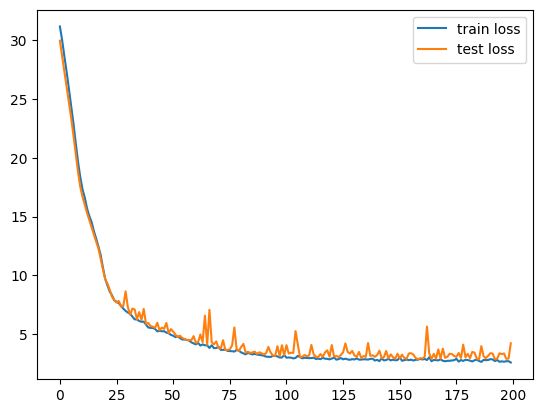

4.233603000640869


In [237]:
# ----------------------------------------------------------------------------------------------------------------
#    initialize model, loss_function, optimizer & dataloader


model = NeuralNetwork(input_size)
model = model.to(device)                                  # GPU

optimizer = SGD(model.parameters(), lr = learning_rate)
loss_function = torch.nn.L1Loss()

train_dataloader = DataLoader(training_set,                 
                              batch_size = batch_size,       
                              shuffle=True)


# ----------------------------------------------------------------------------------------------------------------
#    train



batch_train_losses = []

epoch_train_losses = []
epoch_evaluation_losses = []

for epoch in range(epochs):

    model.train()

    
    for batch in train_dataloader:
        
        y_true = batch[1]
        input_features = batch[0]
        
        y_pred=model(input_features)
        l1_lambda = 0.01
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss=loss_function(y_pred, y_true) + l1_lambda * l1_norm
        # loss=loss_function(y_pred, y_true)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        batch_loss = loss.item()
        batch_train_losses.append(batch_loss)
    
    epoch_average_loss = np.average(batch_train_losses[-len(train_dataloader):])
    epoch_train_losses.append(epoch_average_loss)

# ----------------------------------------------------------------------------------------------------------------
#   evaluation

    model.eval()
    
    y_true = y_test
    input_features = x_test
    
    y_pred = model(input_features)
    l1_lambda = 0.01
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    loss = loss_function(y_pred, y_true) + l1_lambda * l1_norm
    # loss = loss_function(y_pred, y_true)
    
    evaluation_loss = loss.item()
    epoch_evaluation_losses.append(evaluation_loss)

# ----------------------------------------------------------------------------------------------------------------
#   plot results

plt.plot(epoch_train_losses, label = 'train loss')
plt.plot(epoch_evaluation_losses, label = 'test loss')
plt.legend()

plt.show()
print(epoch_evaluation_losses[-1])